<a href="https://colab.research.google.com/github/Nisarg2104/Drawing-based-Image-Retrieval/blob/main/Final_Drawing_based_image_retrieval_Triplet_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Drawing base image Retrieval using Siamese Network with Triplet Loss**
The repository consists of code for image retrieval of images from drawings based on the sketchy databse. Due to memory and RAM limitations on colab only a basic framework model has been developed on a very small section of database. This can be further extended to a complex model for better results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 1.8MB/s 


In [ ]:
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import tensorflow_addons as tfa
import pickle

from PIL import Image, ImageOps


import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize
LIMIT=7



The functions below read the data from the drive folder containing the data


In [ ]:
animal_list=['lion','tiger','bear', 'fish', 'butterfly', 'monkey','snake','ape','giraffe','camel','bettle','bee','deer','elephant','dolphin','duck','frog','kangaroo','lizard','mouse']

In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/Colab Notebooks/')
print(list(data_dir.glob('*')))
images_dir=data_dir/'Sketchy'/'photo'
sketches_dir=data_dir/'Sketchy'/'sketch'
test_dir=data_dir/'test'
mapper_var=0
mapper={}
rev_mapper={}

def get_file_name(i):
  k=i.count('/')
  while k>0:
    i=i[i.find('/')+1:]
    k=k-1

def get_image_name(i):
  k1=i.find('-')
  s=i[:k1]
  s=s+'.jpg'
  return s

def _normalize_img(img):
    img = tf.cast(img, tf.float32) / 255.
    return img


def get_image_name_map(i):
  kk=len(i)
  if i.find('.')!=-1:
    kk=i.find('.')
  if (i.find('-')!=-1):
    kk=i.find('-')
  i=i[:kk]
  # if i.find('n02131653_10683')!=-1:
  #   n=0
  # elif i.find('n02274259_10675')!=-1:
  #   n=1
  # elif i.find('n01440764_2043')!=-1:
  #   n=2
  # elif i.find('n02325366_11308')!=-1:
  #   n=3
  # else:
  #   n=4
  if i not in mapper.keys():
    mapper[i]=len(mapper)
    rev_mapper[len(mapper)-1]=i

  return mapper[i]

def get_name(i):
  # if i==0:
  #   s='n02131653_10683.jpg'
  # elif i==1:
  #   s='n02274259_10675.jpg'
  # elif i==2:
  #   s='n01440764_2043.jpg'
  # elif i==3:
  #   s='n02325366_11308.jpg'
  # elif i==4:
  #   s='n02430045_2684.jpg'
  s=rev_mapper[i]
  s=s[s.find('sketch')+7:]
  s='/content/drive/My Drive/Colab Notebooks/Sketchy/photo/'+s
  s=s+'.jpg'  
  return s

[PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of Drawing based image retrieval Triplet Network.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/model.py'), PosixPath('/content/drive/My Drive/Colab Notebooks/utils.py'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of SVM (1).ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of SVM.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of Copy of SVM.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Untitled0.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of DeepLearning.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of fastai_v2_starter.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of 01_intro.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Untitled1.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/DeepLearning.ipynb'), PosixPath('/content/drive/My Drive/Colab Notebooks/Untitled2.ipynb'), Posi

In [ ]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [ ]:
nb_classes = 5
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, 1)

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,256,256,1)
    """
    # (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

    # assert K.image_data_format() == 'channels_last'
    # x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    # x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)


    temp_labels=[]
    temp_images=[]
    training_data=[]

    repeat=1
    count_class=0
    for name in animal_list:
      ex=0
      sketch_d=pathlib.Path(str(sketches_dir)+'/'+str(name))
      if (not pathlib.Path.exists(sketch_d)):
        continue
      for sketch in sketch_d.iterdir():
        k=np.array(PIL.ImageOps.grayscale(PIL.Image.open(str(sketch))))
        # plt.imshow(k)
        # plt.show()
        # k=_normalize_img(k)
        for i in range(repeat):
          training_data.append([np.array(k[:, :,np.newaxis]),[(get_image_name_map((str(sketch))))] ])
        ex+=1
        if ex==20: 
          break
      count_class+=1
      if count_class==70:
        break


    training_data=np.array(training_data)
    np.random.shuffle(training_data)
    print(training_data[0][0].shape)
    for features,label in training_data:
      temp_images.append(features)
      temp_labels.append(label)
    
    temp_labels=np.array(temp_labels)
    temp_images=np.array(temp_images)
    x_train_origin=temp_images
    y_train_origin=temp_labels

    testing_data=[]
    # for sketch_d in test_dir.iterdir():
    #   k=np.array(PIL.Image.open(str(sketch)))
    #   # k=_normalize_img(k)
    #   for i in range(repeat):
    #     testing_data.append([np.array(k[:, :, np.newaxis]),[(get_image_name_map((str(sketch))))] ])
    
    temp_labels=[]
    temp_images=[]
    testing_data=np.array(testing_data)
    np.random.shuffle(testing_data)
    for features,label in testing_data:
      temp_images.append(features)
      temp_labels.append(label)

    temp_labels=np.array(temp_labels)
    temp_images=np.array(temp_images)
    x_test_origin=temp_images
    y_test_origin=temp_labels
    print(x_train_origin[0].shape)
    dataset_train = []
    dataset_test = []

    nb_classes=len(mapper)
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)

    label_images=[]
    for i in range(nb_classes):
      #  k=np.array(PIL.Image.open(str(images_dir/(get_name(i)))))
       k=ImageOps.grayscale(Image.open(str(images_dir/(get_name(i)))))
       k=_normalize_img(np.array(k))
       label_images.append(np.array(np.array(k)[:, :, np.newaxis]))
    label_images=np.array(label_images)
       

        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin, label_images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(256, 256, 1)
(256, 256, 1)
Checking shapes for class 0 (train) :  (3, 256, 256, 1)
Checking shapes for class 0 (test) :  (0,)
Checking first samples


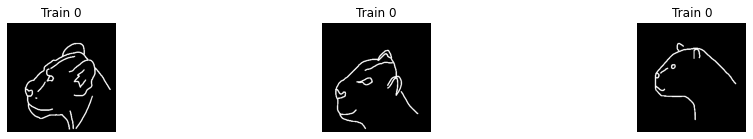

<Figure size 1152x144 with 0 Axes>

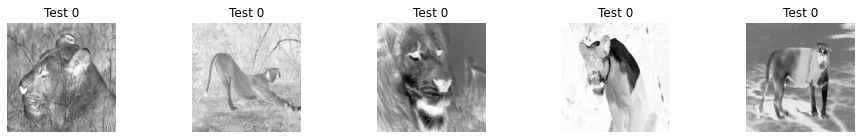

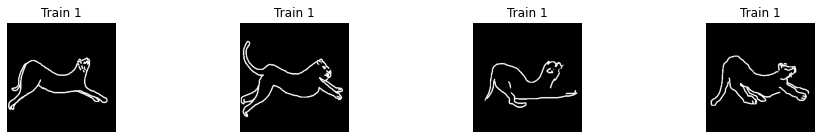

<Figure size 1152x144 with 0 Axes>

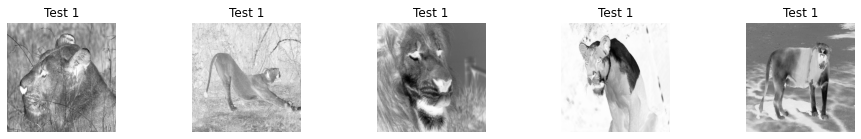

In [ ]:
dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin, label_images = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)
    DrawPics(label_images,5,template='Test {}',classnumber=i)


In [ ]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test
    
    yy=label_images

    m, w, h,c = X[0].shape
    
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = yy[anchor_class][:,:,:]
        triplets[2][i,:,:,:] = yy[negative_class][:,:,:]
        # plt.imshow(Y[anchor_class])
        # plt.show()

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

In [ ]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test
    yy=label_images

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

**A very simple and generalised network is used here due to RAM and Memory constraints on Google Colab. It can further be extended to complex models for better results**

In [ ]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''

    network = Sequential()
    network.add(Conv2D(32, (3,3), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(BatchNormalization())

    network.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(BatchNormalization())

    network.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(BatchNormalization())


    network.add(Flatten())
    network.add(Dense(128, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    # network.add(Dense(embeddingsize, activation=None,
    #                kernel_regularizer=l2(1e-3),
    #                kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network
   
            
    

In [ ]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [ ]:
def build_model(input_shape, network, margin=0.5):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [ ]:
def get_class_encodings(network):
  encoding=[]
  
  encoding.append(network(label_images))
  encoding= np.array(encoding)
  return np.array(encoding)

def predict_class(network, images, class_encoding):
  enc=network(images)
  ans=[]
  thres=0.05
  at=5
  for j in enc:
    dista=[]
    z=-1
    distm= float('inf') 
    for i in range(label_images.shape[0]):
     
      kk=compute_dist(np.array(j),class_encoding[0][i])
      dista.append([kk,i])
      if kk < distm:
        distm=kk
        z=i
    print(dista,z)
    dista.sort()
    # plt.imshow(label_images[z][:,:,0])
    # plt.show()
    temp=[]
    for j in range(at):
      temp.append(dista[j][1])
    ans.append(temp)
  return np.array(ans)

In [ ]:
def get_class_encodings(network):
  encoding=[]
  
  encoding.append(network(label_images))
  encoding= np.array(encoding)
  return np.array(encoding)

def predict_class(network, images, class_encoding):
  enc=network(images)
  ans=[]
  thres=0.4
  at=5
  for j in enc:
    dista=[]
    z=-1
    distm= float('inf') 
    temp=[]
    for i in range(label_images.shape[0]):
     
      kk=compute_dist(np.array(j),class_encoding[0][i])
      dista.append([kk,i])
      if kk<thres:
        temp.append(i)
    ans.append(temp)
  return np.array(ans)

In [ ]:


network = build_network(input_shape,embeddingsize=5)
network_train = build_model(input_shape,network)
optimizer = Adam(lr = 0.01)
network_train.compile(loss=None,optimizer=optimizer)
# get_batch_random(150)
# network_train.summary()
# plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
# print(network_train.metrics_names)
# n_iteration=0
network_train.fit(get_batch_random(250),batch_size=16,epochs=10)





Epoch 1/10
16/16 [==============================] - 57s 3s/step - loss: 5.7937
Epoch 2/10
16/16 [==============================] - 56s 3s/step - loss: 9.7962
Epoch 3/10
16/16 [==============================] - 56s 3s/step - loss: 10.7338
Epoch 4/10
16/16 [==============================] - 56s 3s/step - loss: 9.7534
Epoch 5/10
16/16 [==============================] - 56s 3s/step - loss: 8.5126
Epoch 6/10
16/16 [==============================] - 56s 3s/step - loss: 7.4022
Epoch 7/10
16/16 [==============================] - 56s 3s/step - loss: 6.4565
Epoch 8/10
16/16 [==============================] - 55s 3s/step - loss: 5.6512
Epoch 9/10
16/16 [==============================] - 55s 3s/step - loss: 4.9682
Epoch 10/10
16/16 [==============================] - 63s 4s/step - loss: 4.4764


In [ ]:
class_encodings=get_class_encodings(network)

print(x_test_origin.shape)
# for i in x_test_origin:
#   im = i[:,:,0]
#   plt.imshow(np.array(im),cmap='gray')
#   plt.show()

pred=predict_class(network,x_train_origin,class_encodings)
truth=y_train_origin.reshape(y_train_origin.shape[0])

acc=0
for i in range(truth.shape[0]):
  pres=False
  if truth[i] in pred[i]:
    acc+=1
    
print(acc/truth.shape[0])


(0,)
0.5444444444444444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
network_train.fit(get_batch_random(250),batch_size=16,epochs=10)


In [ ]:
class_encodings=get_class_encodings(network)

print(x_test_origin.shape)
# for i in x_test_origin:
#   im = i[:,:,0]
#   plt.imshow(np.array(im),cmap='gray')
#   plt.show()

pred=predict_class(network,x_train_origin,class_encodings)
truth=y_train_origin.reshape(y_train_origin.shape[0])
print(truth)
print(pred)

acc=0
for i in range(truth.shape[0]):
  pres=False
  for j in range(len(pred[0])):
    if pred[i][j]==truth[i]:
      pres=True
  if pres:
    acc+=1
    
print(acc/truth.shape[0])

Checking batch width, should be 3 :  3
Shapes in the batch A:(2, 256, 256, 1) P:(2, 256, 256, 1) N:(2, 256, 256, 1)
Shapes in the hardbatch A:(2, 256, 256, 1) P:(2, 256, 256, 1) N:(2, 256, 256, 1)


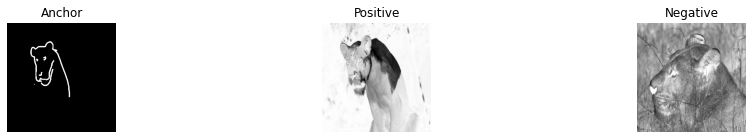

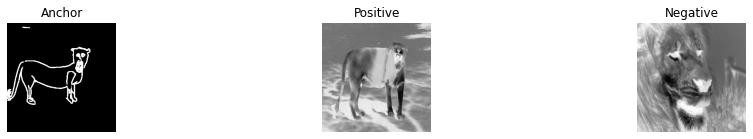

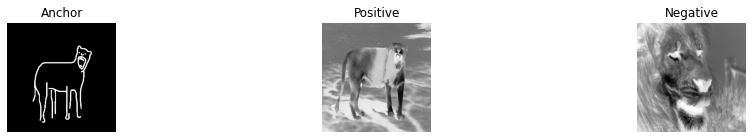

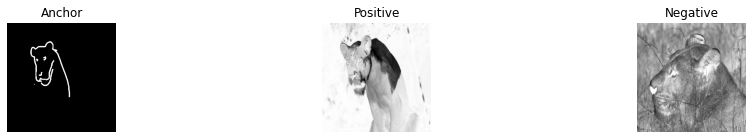

In [ ]:

triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)
hardtriplets = get_batch_hard(3,1,1,network)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)